## The Ultimate Inc. Data Science Challenge

### Part 1.Exploratory Data Analysis

### Objectives

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location.

1.Aggregate these login counts based on 15 minute time intervals.<br>
2.Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.<br>
3.Report/illustrate important features of the demand,such as daily cycles.<br>

In [1]:
# importing necessary modules
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns

from datetime import datetime
import pickle
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [36]:
#pip install xgboost

     |████████████████████████████████| 1.2 MB 608 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# load json file as string
json_str=json.load(open('logins.json'))

#load json file as  pandas dataframe
logins=pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
#adding a columns that shows number of frequency
logins['freq']=1
#convert  date to datetime object, and set it as the index
logins_data=logins.set_index(pd.to_datetime(logins['login_time'],unit='s'))[['freq']]
logins_data.head()

,freq
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


## Process time_series data into 15 chunks


In [6]:
# resample the index,so that times is represented in 15 min chunks
login_data15=logins_data.resample('15Min').sum()
login_data15.head()

,freq
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


## Visualize processed data


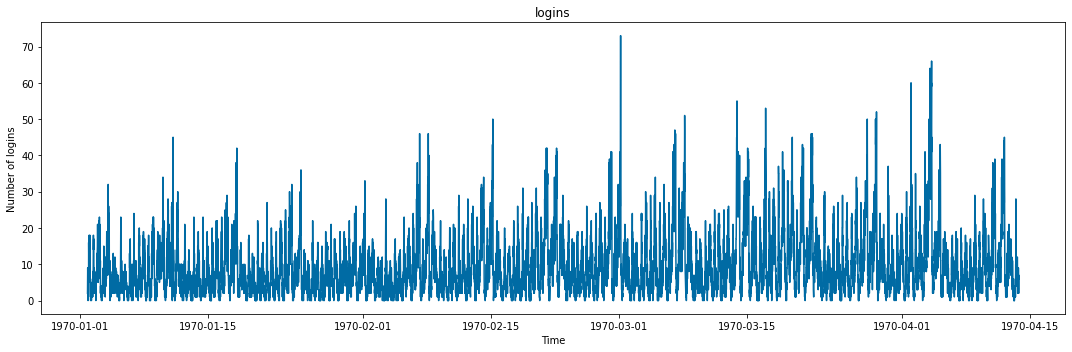

In [7]:
# scatterplot of the binned data
fig,ax=plt.subplots(figsize=(15,5))
plt.plot(login_data15.index,login_data15.freq)
plt.xlabel('Time')
plt.ylabel('Number of logins')
plt.title('logins')
plt.tight_layout()

It does look like there is an underlying pattern in the data, but it is hard to see at this scale. Steps need to be taken to better understand the data.

## Better Understanding of time series data


 1.We can see a entire time series as larger chunks.<br>
 2.Find out the busiet time of the day.<br>
 3.Find out the specific days sperately.<br>

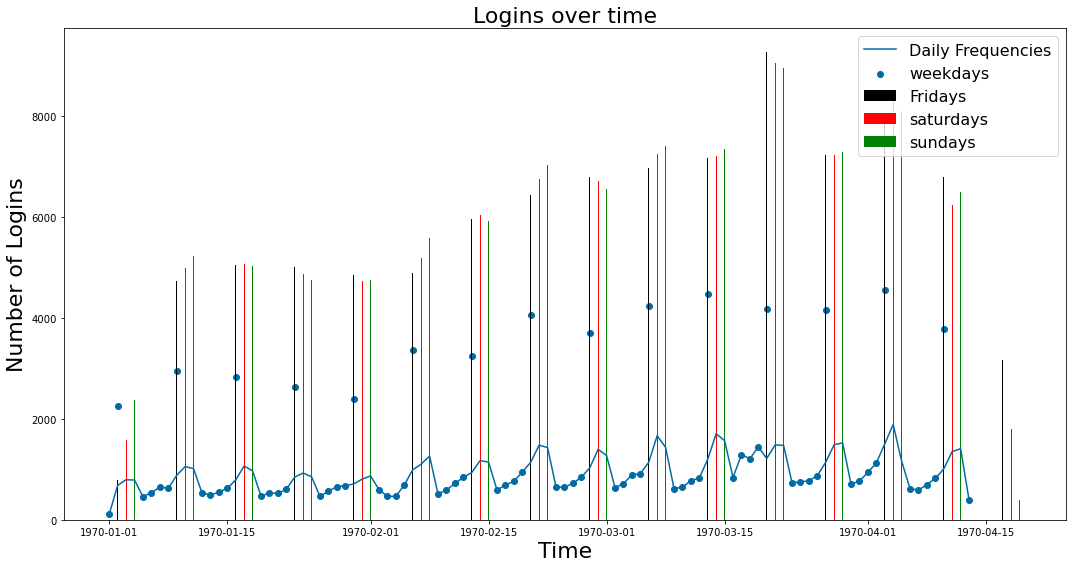

In [8]:
# bin the data  by the day

logins_daily = logins_data.resample('D').sum()
logins_biz_day=logins_data.resample('B').sum()
fridays= logins_data.resample('W-FRI').sum()
saturdays=logins_data.resample('W-SAT').sum()
sundays= logins_data.resample('W-SUN').sum()

# # lime, scatterplot ,and histograms of the binned data

fig,ax =plt.subplots(figsize= (15,8))
plt.xlabel ('Time' ,fontsize = 22)
plt.ylabel ('Number of Logins', fontsize =22)
plt.title ('Logins over time',fontsize =22)

plt.bar(fridays.index,fridays.freq, align='center',width= 0.1,label ='Fridays',color ='Black')
plt.bar(saturdays.index,saturdays.freq,align='center',width=0.1,label ='saturdays',color ='r')
plt.bar(sundays.index,sundays.freq,align='center',width=0.1,label = 'sundays',color ='g')
plt.plot(logins_daily.index,logins_daily.freq,label='Daily Frequencies')
plt.scatter(logins_biz_day.index,logins_biz_day.freq,label='weekdays')

plt.legend(loc= 'upper right',fontsize =16)
plt.tight_layout()


 The above graph shows saturday has most logins and weekends are most busier than weekends.

In [9]:
# Finding hourly trend by day of week

In [10]:
#find hourly logins
daily_logins= logins_data.resample('H').sum()
#make column which makes day of week : mon =0 sunday =6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week']= day_of_week
#add column with hour
daily_logins['hour']= [time.hour for time in daily_logins.index]

In [11]:
daily_logins

,freq,day_of_week,hour
login_time,,,
1970-01-01 20:00:00,24,3,20
1970-01-01 21:00:00,9,3,21
1970-01-01 22:00:00,21,3,22
1970-01-01 23:00:00,58,3,23
1970-01-02 00:00:00,53,4,0
...,...,...,...
1970-04-13 14:00:00,32,0,14
1970-04-13 15:00:00,19,0,15
1970-04-13 16:00:00,22,0,16


In [12]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'freq', index = 'hour', columns = 'day_of_week', 
                                   aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()


In [13]:
avg_hourly_logins_df.head()

,hour,day_of_week,avg_num_logins
0,0,Monday,35.400000
1,0,Tuesday,43.357143
2,0,Wednesday,49.071429
3,0,Thursday,58.285714
4,0,Friday,65.000000


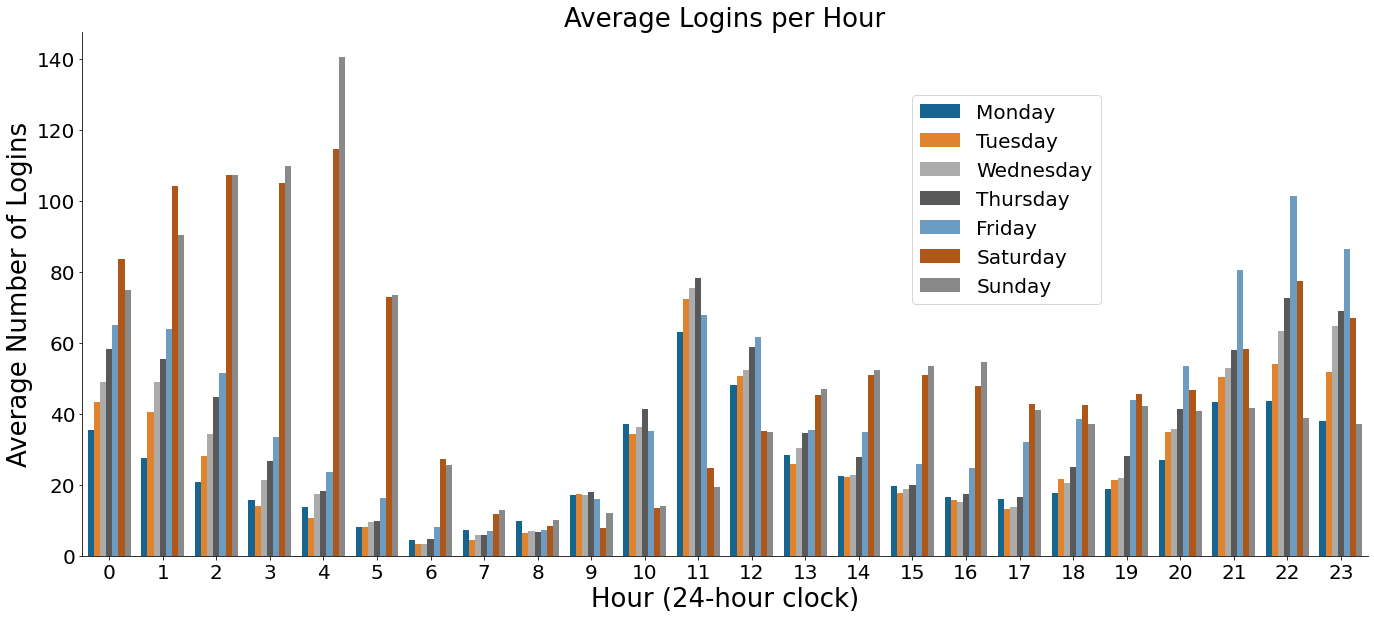

In [14]:
# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)

The bar graph shows the heaviest usage occurs during the early hours (1 AM - 5 AM) on Saturday and Sunday. During the weekdays there are smaller spikes in usage during lunch hours (11 am to noon), and in the evening (9 PM - 11 PM).

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?<br>
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:<br>
1.how you will implement the experiment<br>
2.what statistical test(s) you will conduct to verify the significance of the observation<br>
3.how you would interpret the results and provide recommendations to the city operations team along with any caveats.<br>

To clarify the problem I am making the following assumptions:

There is an electronic record of the number of cars that use the bridge. 

1.This is a reasonable assumption, as to reimburse the partner drivers, the drivers would need a record of crossing.


2.There is historical data on bridge use

The key metric I would use is change in weekday activity. 

Specifically, during the daytime hours on weekdays, is there an increase of cars entering the bridge from Gotham AND during the night is there an increase of cars entering the bridge from Metropolis. I choose this metric because it required only two assumptions, is easily measured, and doesn't require waiting for reimbursement data to accumulate (as I don't know how long the reimbursement process takes).

In order to answer the above questions I would use two hypothesis tests.


H0: There is no difference between the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H2: There is an INCREASE in the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H0: There is no difference between the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H2: There is an INCREASE in the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

I would use a one-tailed Z-test to determine the p-value of each hypothesis.

If the p-value is less than 0.05 for BOTH tests I would reject the null hypotheses and recommend the reimbursement program continue, with the caveat that the study should be repeated in a year with more data.

If the p-value is greater than 0.05 for BOTH tests I would fail to reject the null hypotheses and recommend that a different program be developed to increase partner driving between the two cities.

If the p-value is mixed, so only one hypothesis has a p-value less than 0.05 I would recommend that the analysis is inconclusive and that further investigation is needed.



## Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice).<br>

1.What fraction of the observed users were retained?<br>
2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.<br>
3.Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Assumptions Made
The date of when the data was pulled is not given, so I cannot tell if they had a trip in the 30 days before that date, nor is a user ID given. Thus, I will assume:
That the most recent trip taken was the day the data was pulled
Each row represents a summary of a unique user.

In [15]:
# load the json.file
data=json.load(open("ultimate_data_challenge.json"))

In [16]:
#put data into dataframe
user_data= pd.read_json("ultimate_data_challenge.json")

In [17]:
user_data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [18]:
#convert dates to datetime objects
user_data['signup_date']= pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date']= pd.to_datetime(user_data['last_trip_date'])

In [19]:
#find the date the data was pulled
pull_date=user_data.last_trip_date.max()

#determine 30 days previous to the pull day
cut_off_day=pull_date-pd.Timedelta('30days')
# determine active  cases 0= inactive and 1 = active
user_data['active_status']=(user_data.last_trip_date>cut_off_day).astype('int')
#add dummies to  categorical data 
user_data=pd.get_dummies(user_data ,columns=['city','phone'])

In [20]:
# seperate get active and inactive users
active_user= user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

In [21]:
# percentage of retained user
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))


36.62 percent of users were retained.


In [22]:
# calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]



In [23]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 
                                                                                2:'inactive_mean', 3:'inactive_std'})

In [24]:
stats_df

,active_mean,active_std,inactive_mean,inactive_std
avg_dist,5.118977,4.627946,6.188478,6.213027
avg_rating_by_driver,4.763121,0.324566,4.786876,0.503869
avg_rating_of_driver,4.593364,0.538166,4.607018,0.664816
avg_surge,1.073720,0.163183,1.075367,0.250219
surge_pct,9.128165,15.489344,8.688548,22.132211
ultimate_black_user,0.511141,0.499890,0.299621,0.458099
weekday_pct,62.214604,29.068319,60.181597,40.985698
city_Astapor,0.219661,0.414029,0.394825,0.488821
city_King's Landing,0.344457,0.475204,0.120637,0.325711
city_Winterfell,0.435882,0.495885,0.484538,0.499769


Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

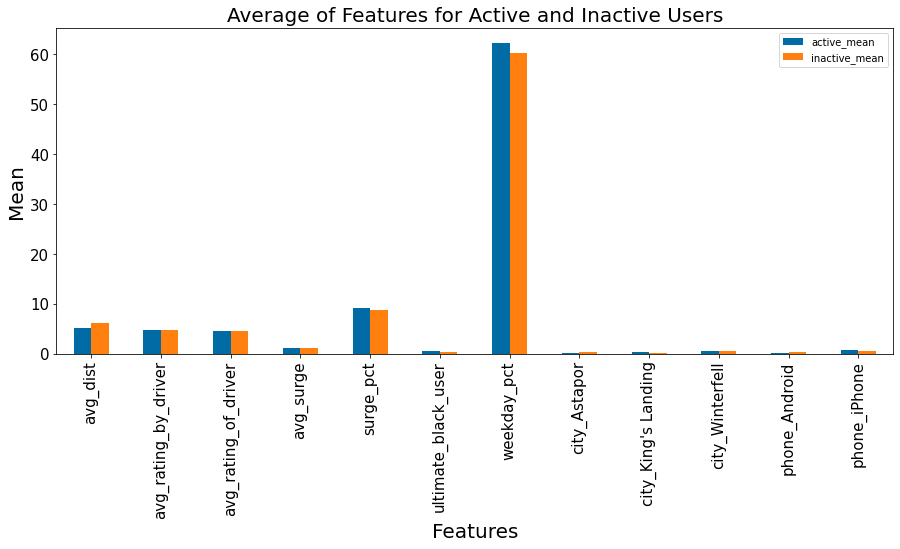

In [25]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)

The bar graph of the statistcs shows there is not a pronounce difference between the average of the features for active and inactive users. It also shows the weekday_pct feature has a much larger scale than the others, so the data may need to be normalized.

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

This is a binary classification problem with both numerical and categorical data with 50,000 data points. XGBoost is appropriate for the data, fast, and memory efficient. Other models that would be appropriate for this data would be random forests and logistic regression. One of the drawbacks of using a tree-based model is interpretation is not as straightforward as it is with linear models.

In [26]:
user_data

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.0,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,1,0,1,0,0,1
49996,1,2014-01-24,NaN,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,0,1,0,0,0,1
49997,0,2014-01-31,5.0,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,0,0,0,1,1,0
49998,2,2014-01-14,3.0,1.00,2014-01-15,0.0,False,100.0,4.58,3.5,0,1,0,0,0,1


## Optimization of XGBoost Classifer Model

1.split data into training and test sets <br>
2.optimize hyperparameters using the training set and random crossfold validation<br>
3.validate using an unoptimized model AND the test set<br>
4.train optimized model using the entire feature set<br>

In [27]:
#define features and target
X= user_data[feature_columns]
y=user_data.active_status
# split traun and test data
X_train,X_test,y_train,y_test =train_test_split(X,y ,test_size=0.3,random_state=123)

## Hyperparameter optimization

In [28]:
#dictionary of parameters to optimize, and the range of optimization values
parameters ={
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95,0.9],
    'subsample':[1,0.8],
    'learning_rate':[0.25,0.2,0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1,2,3]
}

In [30]:
#instantiate XGBOSST classifier
xg_clf = XGBClassifier(objective ='binary:logistic',random_state =42,n_estimators =10,max_depth=8)
# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=8, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=10, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, valid

In [31]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 1, 'scale_pos_weight': 0.95, 'subsample': 0.8}
0.7833142878095526


In [34]:
# optimized parameters

optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'subsample':0.8, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.25, 
                        'gamma': 3
                       }

In [35]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8057.


In [37]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.7863.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

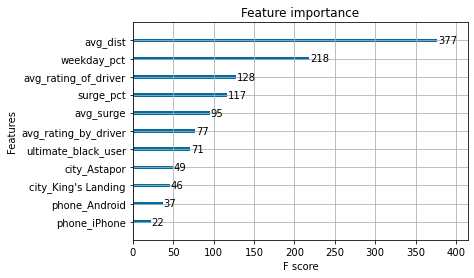

In [38]:
plot_importance(xg_clf_opt)

The factors that most heavily influence rider retention are the average distance in miles per trip taken in the first 30 days after signup and the percent of the user's trips occuring during a weekday.